## Описание набора данных

Для выполнения лабораторной используется тот же набор данных, что и в первой работе — Automobile Dataset.
Источник: Kaggle – Automobile Dataset

Данные содержат информацию о характеристиках автомобилей: мощности двигателя, массе, ускорении, объёме двигателя, расходе топлива и т.д.

## 1. Импорт библиотек и загрузка данных

In [7]:
import pandas
import numpy
import matplotlib.pyplot as pyplot
import seaborn
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

%matplotlib inline

data = pandas.read_csv("Automobile.csv")
print(data.head())

                        name   mpg  cylinders  displacement  horsepower  \
0  chevrolet chevelle malibu  18.0          8         307.0       130.0   
1          buick skylark 320  15.0          8         350.0       165.0   
2         plymouth satellite  18.0          8         318.0       150.0   
3              amc rebel sst  16.0          8         304.0       150.0   
4                ford torino  17.0          8         302.0       140.0   

   weight  acceleration  model_year origin  
0    3504          12.0          70    usa  
1    3693          11.5          70    usa  
2    3436          11.0          70    usa  
3    3433          12.0          70    usa  
4    3449          10.5          70    usa  


## 2. Добавление нового атрибута

Для улучшения анализа и выявления дополнительных закономерностей был добавлен новый атрибут —
power_density = отношение мощности двигателя к массе автомобиля (лошадиные силы на тонну):

***power_density = horsepower / weight * 1000***

Этот признак отражает удельную мощность автомобиля и позволяет точнее различать лёгкие и мощные модели.

In [8]:
data["power_density"] = data["horsepower"] / data["weight"] * 1000
print(data[["horsepower", "weight", "power_density"]].head())

   horsepower  weight  power_density
0       130.0    3504      37.100457
1       165.0    3693      44.679123
2       150.0    3436      43.655413
3       150.0    3433      43.693562
4       140.0    3449      40.591476


## 3. Очистка данных
Удаление дубликатов, обработка пропусков и выбросов.

In [9]:
data = data.drop_duplicates() # удаление дублей

data["horsepower"].fillna(data["horsepower"].median(), inplace=True) # заполнение пропусков  в horsepower медианой

def drop_outliers(df, col): # удаление выбросов по IQR
    q1, q3 = df[col].quantile([0.25, 0.75])
    iqr = q3 - q1
    low, high = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    return df[(df[col] >= low) & (df[col] <= high)]

for c in ["mpg", "horsepower", "weight", "displacement"]:
    data = drop_outliers(data, c)

print("Осталось записей:", len(data))

Осталось записей: 386


## 4. Графики зависимостей

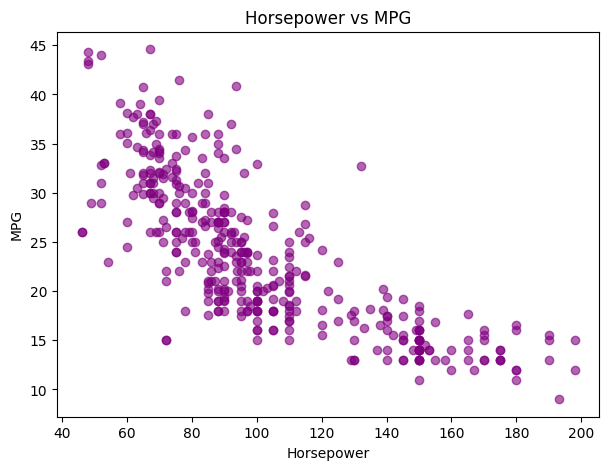

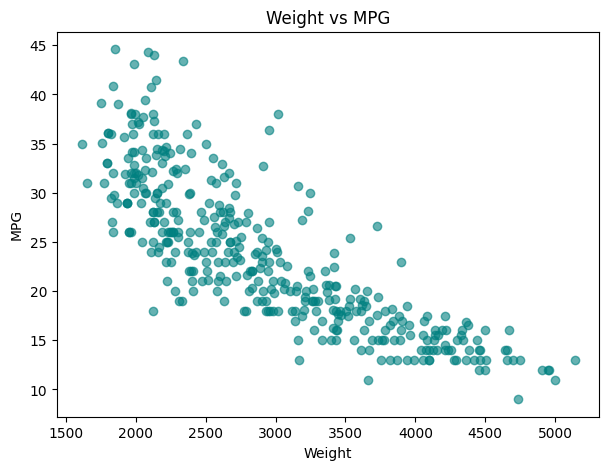

In [10]:
pyplot.figure(figsize=(7,5))
pyplot.scatter(data["horsepower"], data["mpg"], alpha=0.6, color="purple")
pyplot.xlabel("Horsepower")
pyplot.ylabel("MPG")
pyplot.title("Horsepower vs MPG")
pyplot.show()

pyplot.figure(figsize=(7,5))
pyplot.scatter(data["weight"], data["mpg"], alpha=0.6, color="teal")
pyplot.xlabel("Weight")
pyplot.ylabel("MPG")
pyplot.title("Weight vs MPG")
pyplot.show()

## 5. Подготовка данных для кластеризации

In [11]:
features = data[["horsepower", "weight", "mpg", "displacement", "power_density"]]  # только числовые признаки
features = features.fillna(features.median())  # заполняем пропуски

scaler = StandardScaler()
scaled = scaler.fit_transform(features)

## 6. Определим оптимальное количество кластеров (метод локтя)

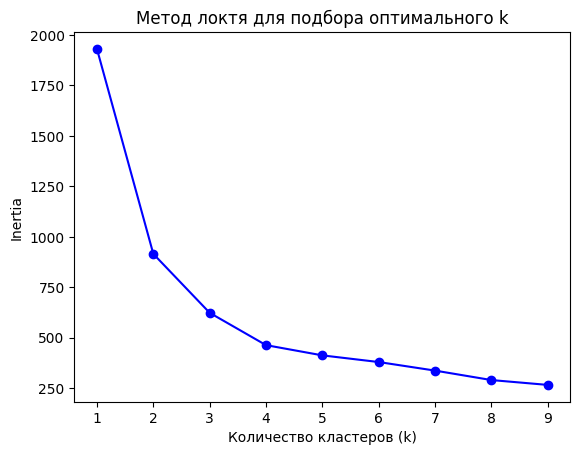

In [12]:
distortions = []
K = range(1, 10)

for k in K:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(scaled)
    distortions.append(model.inertia_)

pyplot.plot(K, distortions, 'bo-')
pyplot.xlabel('Количество кластеров (k)')
pyplot.ylabel('Inertia')
pyplot.title('Метод локтя для подбора оптимального k')
pyplot.show()

## 7. Применим KMeans

In [13]:
kmeans = KMeans(n_clusters=3, random_state=42)
data["cluster"] = kmeans.fit_predict(scaled)

print(data[["horsepower", "mpg", "cluster"]].head())

   horsepower   mpg  cluster
0       130.0  18.0        2
1       165.0  15.0        2
2       150.0  18.0        2
3       150.0  16.0        2
4       140.0  17.0        2


## 8. Визуализация кластеров

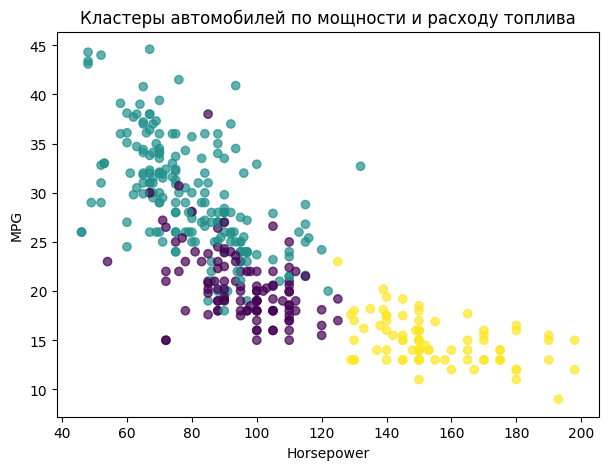

In [14]:
pyplot.figure(figsize=(7,5))
pyplot.scatter(data["horsepower"], data["mpg"], c=data["cluster"], cmap="viridis", alpha=0.7)
pyplot.xlabel("Horsepower")
pyplot.ylabel("MPG")
pyplot.title("Кластеры автомобилей по мощности и расходу топлива")
pyplot.show()

## Выводы по результатам кластеризации:

1. Был добавлен новый атрибут power_density, отражающий удельную мощность автомобиля.

2. После обработки данных удалены дубликаты и выбросы, пропуски в horsepower заменены медианой.

3. Графики horsepower vs mpg и weight vs mpg показали наличие трёх естественных групп автомобилей.

4. Метод K-Means подтвердил это:

- Кластер 0 — лёгкие и экономичные автомобили с малой мощностью.
- Кластер 1 — автомобили среднего класса (сбалансированные характеристики).
- Кластер 2 — тяжёлые, мощные автомобили с высоким расходом топлива.

5. Кластеры отражают реальную рыночную сегментацию автомобилей и могут быть использованы для классификации или анализа характеристик.